# Degenerate Electrons

In white dwarfs, electron degeneracy pressure provides the dominant support against gravity.  Electrons are fermions, and when the density of the star is high, they are packed closely together.  Quantum mechanical effects come into play, and the electrons no longer behave as an ideal gas, but instead exhibit large pressure even at very low (or zero) temperature.

The origin of this is [Fermi-Dirac statistics](https://en.wikipedia.org/wiki/Fermi%E2%80%93Dirac_statistics)&mdash;no two electrons can occupy the same state, so as they get confined to a smaller and smaller volume, they need to take on larger momenta.

The distribution function describes the properties of the electrons, and has the following meaning: $n(p) d^3 x d^3 p$ is the number of particles with momentum $p$ in a volume $d^3x$.  Our distribution function is:


$$n(p) = \frac{2}{h^3} \frac{1}{e^{\mathcal{E}(p)/{k_B T} - \Psi} + 1}$$

where $\mathcal{E}$ is the kinetic energy of the electron, $T$ is the temperature, and $\Psi$ is the _degeneracy parameter_ which is related to the chemical potential, $\mu$, and the [Fermi energy](https://en.wikipedia.org/wiki/Fermi_energy), $\mathcal{E}_F$, as:

$$\Psi = \frac{\mu - m_e c^2}{k_B T} = \frac{\mathcal{E}_F}{k_B T}$$

```{note}
Some sources use $\eta$ instead of $\Psi$ for the degeneracy parameter
```

The electrons are degenerate when $\Psi \gg 1$, which means that the Fermi energy is much greater than the thermal energy.  The electrons behave as an ideal gas when $-\Psi \gg 1$ (in this case, the $+1$ in the denominator of $n(p)$ is insignificant and we get the Maxwell-Boltzmann distribution).

To get the _number density_, we integrate over all momenta:

$$n = \int n(p) d^3 p$$

The pressure and specific internal energy, $e$, are then found as:

$$P = \frac{1}{3} \int n(p) v(p) p d^3 p$$
$$\rho e = \int n(p) \mathcal{E}(p) d^3 p$$

## Transition to Degeneracy

Let's look at the behavior of the distribution function.  Consider:

$$F(\mathcal{E}) = \frac{1}{e^{\mathcal{E}/k_B T - \Psi} + 1}$$

let's define

$$\xi \equiv \frac{\mathcal{E}}{k_B T}$$

then we have

$$F(\xi) = \frac{1}{e^{\xi - \Psi} + 1}$$

and for each choice of $\Psi$ we have a unique distribution.

We note that $\xi/\Psi = \mathcal{E}/\mathcal{E}_F$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def F(xi, psi=100):
    return 1.0 / (np.exp(xi - psi) + 1)

Let's look at the case of $\Psi > 1$

Text(0.5, 0, '$\\mathcal{E}/\\mathcal{E}_F$')

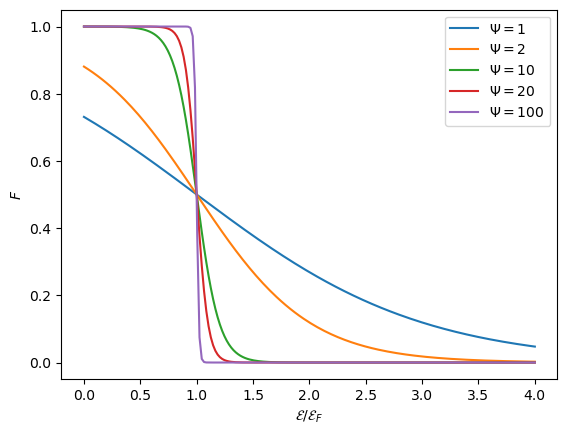

In [3]:
fig, ax = plt.subplots()

# we'll work in terms of r = xi / Psi
r = np.linspace(0, 4, 200)

for psi in [1, 2, 10, 20, 100]:
    ax.plot(r, F(psi * r, psi=psi), label=f"$\Psi = {psi}$")
    
ax.legend()
ax.set_ylabel("$F$")
ax.set_xlabel(r"$\mathcal{E}/\mathcal{E}_F$")

As we see, as $\Psi \rightarrow \infty$, the distribution, $F(\mathcal{E})$ becomes a step function.  This is the limit of complete degeneracy, and we have:

$$F(\mathcal{E}) = \left \{ \begin{array}{cc} 1 & \mathcal{E} < \mathcal{E}_F \\
                                              0 & \mathcal{E} > \mathcal{E}_F \end{array} \right .$$

We can alternately use the Fermi momentum, $p_F$ to describe the location of the step.

With this form, the integral for number density is trivial:

$$n_e = \frac{8\pi}{h^3} \int_0^{\mathcal{p}_F} p^2 dp$$

where we switched to spherical coordinates in momentum space: $d^3p \rightarrow 4\pi p^2 dp$.

## Computing the Degeneracy Parameter

For other values of $\Psi$, we have a problem:

$$n_e = \frac{8\pi}{h^3} \int_0^\infty \frac{p^2}{e^{\mathcal{E}(p)/k_B T - \Psi} + 1} dp$$

We don't know what the value of $\Psi$ is ahead of time.  Instead, we typically know what the density of the star is, and we can find the
number density of electrons as:

$$n_e = \frac{\rho Y_e}{m_u}$$

where $Y_e$ is the electron fraction (typically around $1/2$ for compositions heavier than hydrogen).  This means that given $\rho, T$,
we can solve for $\Psi$.

Once we have $\Psi$, we can then find the pressure and energy of the gas.

### Finding the trend of $\Psi$ with $\rho, T$

Let's now implement an algorithm to find the $\Psi$ that corresponds to an input $\rho$ (or $n_e$) and $T$.

We first need a function to compute $n_e$ given a $T$ and a guess for $\Psi$.  

The kinetic energy of a particle can be found from the relativisitic expression:

$$\mathcal{E}(p) = m_e c^2 \left [ \sqrt{1 + \left ( \frac{p}{m_e c} \right )^2 } - 1 \right ]$$

```{note}
This has the proper limit in the non-relativistic case, $|p| \ll m_e c$:

$$\mathcal{E} = \frac{p^2}{2m_e}$$

Defining $x = p/(m_e c)$ and $\alpha = m_e c^2 / (k_B T)$, our integral becomes:

$$n_e = \frac{8\pi}{h^3} (m_e c)^3 \int_0^\infty \frac{x^2 dx}{e^{\alpha (\sqrt{1 + x^2} - 1) - \Psi} + 1}$$

We need to do this numerically

Let's write a function that returns the integrand.  Note, we run a risk of the exponential in the denominator overflowing, especially when $\alpha$ is large ($T$ is small).  So we take `exp(500)` to be infinite and set the integrand to zero.

In [4]:
def integrand(x, alpha, psi):
    if alpha * (np.sqrt(1 + x**2) -1) - psi > 300:
        return 0.0
    return x**2 / (np.exp(alpha * (np.sqrt(1 + x**2) -1) - psi) + 1.0)

we'll need the constants

In [5]:
# CGS constants

h_planck = 6.63e-27
k_B = 1.38e-16
m_e = 9.11e-28
m_u = 1.67e-24
c = 2.99792e10

Now a function that returns $n_e$.  This does the integral using SciPy, and adds in the physical constants to give us $n_e$. 

In [6]:
from scipy import integrate, optimize

In [7]:
def compute_ne(T, psi):
    """given a temperature and degeneracy parameter, psi,
    compute the number density of electrons by integrating
    the Fermi-Dirac distribution over all momenta"""
    alpha = m_e * c**2 / (k_B * T)
    I, err = integrate.quad(integrand, 0, np.inf, args=(alpha, psi), epsabs=1.e-10, epsrel=1.e-10)
    ne = 8.0 * np.pi / h_planck**3 * (m_e * c)**3 * I
    return ne

Now we want to do a root find on this, to find the value of $\Psi$ that gives us our desired $n_e$.

In [8]:
def find_psi(rho, T, Ye=0.5):
    
    ne_input = rho * Ye / m_u
    psi_low = -1000
    psi_high = 100000
    
    psi = optimize.brentq(lambda psi: ne_input - compute_ne(T, psi), psi_low, psi_high)
    return psi

In [9]:
find_psi(1, 1.e6, Ye=1/2)

-2.7566778741961664

### Visualizing $\Psi$

In [10]:
def get_psi_rho(rhos, T=1.e7):
    psis = []

    for rho in rhos:
        psi = find_psi(rho, T)
        psis.append(psi)
        
    return psis

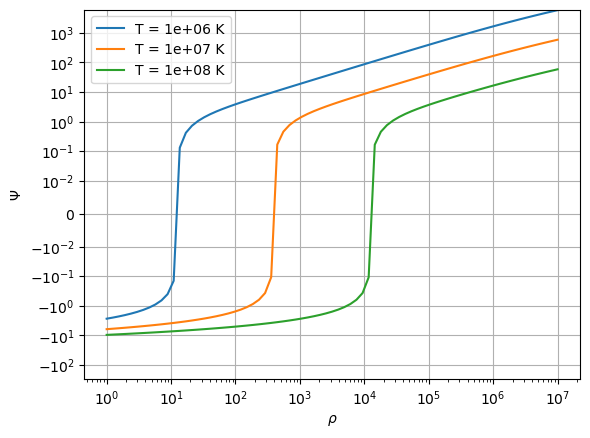

In [11]:
fig, ax = plt.subplots()

rhos = np.logspace(0, 7, 75)

for T in [1.e6, 1.e7, 1.e8]:
    ax.plot(rhos, get_psi_rho(rhos, T=T), label=f"T = {T:5.2g} K")
    
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\Psi$")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1.e-2)
ax.grid()
ax.legend()

Notice that at high $T$ and low $\rho$, the degeneracy parameter becomes negative--this is when we are an ideal gas.

## Computing Pressure

Now, for the pressure, we need $v(p)$:

$$v(p) = \frac{p}{m_e} \left [ 1 + \left (\frac{p}{m_e c} \right )^2 \right ]^{-1/2}$$

our pressure integral becomes:

$$P = \frac{8\pi}{3m_e h^3} (m_e c)^5 \int_0^\infty \frac{x^4}{\sqrt{1 + x^2}} \frac{dx}{e^{\alpha (\sqrt{1 + x^2} - 1) - \Psi} + 1}$$

To do this integral, we first need to compute $\Psi$.  Here's the overall pressure function.  At low temperatures / low densities, we need to ensure that the tolerance used by the integrator is tight to get a good solution.

In [12]:
def p_integrand(x, alpha, psi):
    if alpha * (np.sqrt(1 + x**2) -1) - psi > 500:
        return 0.0
    return x**4 / np.sqrt(1 + x**2) / (np.exp(alpha * (np.sqrt(1 + x**2) -1) - psi) + 1.0)

def p(rho, T, Ye=0.5):
    alpha = m_e * c**2 / (k_B * T)
    psi = find_psi(rho, T, Ye=Ye)
    I, err = integrate.quad(p_integrand, 0, np.inf, args=(alpha, psi), epsabs=1.e-10, epsrel=1.e-12)
    return 8.0 * np.pi / (3 * m_e * h_planck**3) * (m_e * c)**5 * I

In [13]:
def get_p_rho(rhos, T=1.e7):
    ps = []

    for rho in rhos:
        ps.append(p(rho, T))
        
    return ps

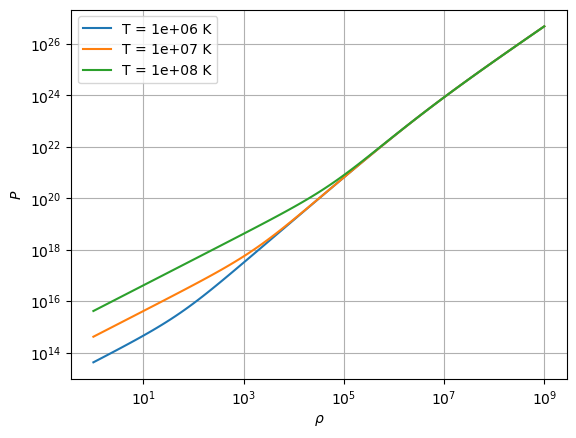

In [14]:
fig, ax = plt.subplots()

rhos = np.logspace(0, 9, 100)

for T in [1.e6, 1.e7, 1.e8]:
    ax.plot(rhos, get_p_rho(rhos, T=T), label=f"T = {T:5.2g} K")
    
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$P$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()

Here you clearly see that hotter temperatures require higher densities before they transition from an ideal gas to degeneracy.  For the coldest line, the $\alpha$ factor is making the exponential overflow, making the solution a bit unstable.

At zero temperature, the pressure integral can be done analytically, and we find:

$$x_F = \left (\frac{3}{8\pi} \right )^{1/3} \frac{h}{m_e c} n_e^{1/3}$$

and then

$$P(x) = \frac{\pi}{3} \left (\frac{m_e c}{h} \right )^3 m_e c^2 \left [ x (2x^2 - 3) (1 + x^2)^{1/2} + 3 \sinh^{-1}x \right ]$$

we can add this line to the pressure plot

In [15]:
def p_zero_temp(rho, Ye=0.5):
    
    # find number density
    n_e = rho * Ye / m_u
    
    # find Fermi momentum
    x_F = (3 / (8 * np.pi))**(1/3) * (h_planck / (m_e * c)) * n_e**(1/3)
    
    P = (np.pi/3) * (m_e * c / h_planck)**3 * m_e * c**2 * (x_F * (2*x_F**2 - 3) * np.sqrt(1 + x_F**2) + 3 * np.arcsinh(x_F))
    return P

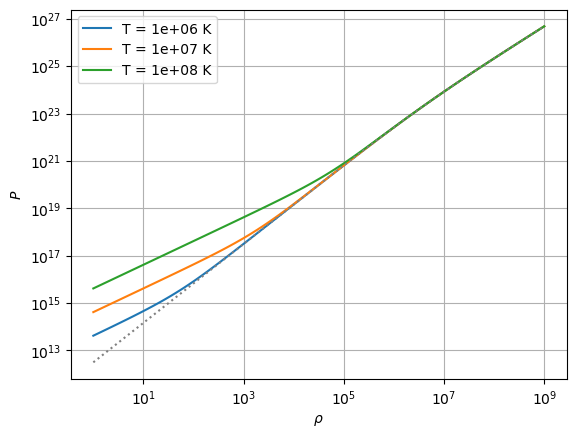

In [16]:
ax.plot(rhos, p_zero_temp(rhos), linestyle=":", color="0.5")
fig

Here we see that this zero-temperature curve works really well at low temperatures and at high densities.